## $$ H = 4E_C n_q^2 - 2E_J \cos(\phi) + \alpha E_J \cos(2\phi - \phi_{ext}) $$
## $$ E_J / E_C = 100 \quad , \quad \phi_{ext} = 0.001\pi $$
## $$ \rightarrow \quad H = 0.04 n_q^2 - 2 \cos(\phi) + \alpha \cos(2\phi - 0.001\pi) $$
## With $\alpha \in [0.5;1]$.. The following is in the $n_q$ basis.

## $$ e^{-i\phi} \rightarrow FT \rightarrow \sum_i |n+1><n|$$
## $$ e^{-i2\phi} \rightarrow FT \rightarrow \sum_i |n+1><n|$$

In [8]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

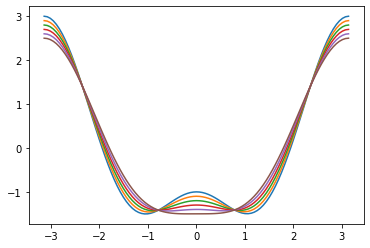

In [12]:
def plot_potential():
    phi = t.linspace(-np.pi,np.pi,101)
    fig, ax = plt.subplots()
    for alpha in np.arange(1,0.4,-0.1):
        ax.plot(phi, -2*t.cos(phi) + alpha*t.cos(2*phi - 0.001*np.pi))
    return
plot_potential()

In [10]:
N = 21
q = t.linspace(-(N - 1)//2,N//2,N)





tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])